# The Vestibular System - Part 2: 
# Sensory Transduction and Information Processing


<img src="data/images/labyrinth_labelled.png", width=350px>

## Preliminaries

In [1]:
# Import the required packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal

# Make the display easy to read
% precision 2

'%.2f'

## Dynamics

### Damped Oscillator

The deflection of the cupula, the sensory element of the SCCs, as a function of head movement can be well approximated by the equations governing a *Damped Oscillator*.
(Details can be found in https://en.wikibooks.org/wiki/Sensory_Systems/Computer_Models/Vestibular_Simulation)

<img src="data/images/1D_movement.png", width=300px>

* x ... position of mass in space
* b ... position of base
* k ... spring constant
* $\delta = b - x$ ... difference

\begin{equation}
    m \ddot{x} = r \dot{\delta} + k * \delta
\end{equation}
\begin{equation}
    m \ddot{b} = m \ddot{\delta} + r \dot{\delta} + k * \delta
\end{equation}

### Laplace Transformation

Differential equations like the one above can be converted into - easily solvable - algebraic equations, by making use of the *Laplace Transofmation*. Given any time course f(t), its Laplace transform F(s) is

\begin{equation}
  F(s) = \int\limits_0^\infty  {f(t) \cdot {e^{ - st}}dt}
\end{equation}
	
while its inverse is

\begin{equation}
  f(t) = \int\limits_S {F(s) \cdot {e^{st}}ds}
\end{equation}

where the integration is over the s-plane, S. s is sometimes referred to as *complex frequency*.

Laplace Transformations are a generalization of Fourier Transformation. With Fourier Transformations we have dealt only with sine waves, $e^{j \omega t}$ . Put another way, we have restricted $s$ to $j \omega$ so that est was restricted to $e^{j \omega t}$. But this is unnecessary, we can let $s$ enjoy being fully complex or $s = \sigma + j \omega$ . This greatly expands the kinds of functions that $e^{st}$ can represent.


With a Laplace transformation, where

\begin{equation}
    \frac{dx}{dt} \rightarrow s \tilde{X} - x(0)
\end{equation}
the differntial equation above is transformed into

\begin{equation}
    \frac{\delta}{sB} = \frac{m * s}{m s^2 + r s + k}
\end{equation}

#### Example: Kick a Damped Oscillator

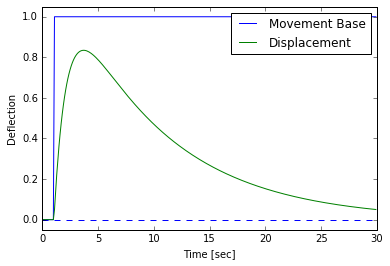

In [2]:
# Import the required modules
from scipy import signal

# Define the system
m, r, k = 1, 1, 0.1
num = [m, 0]
den = [m, r, k]
system = signal.lti(num, den)

# Define the input
t = np.arange(0, 30, 0.1)
x = np.zeros_like(t)
x[t>1] = 1

# Simulate the system response
tout, outSignal, xout = signal.lsim(system, x, t)

# Plot the output
plt.plot(t, x, label='Movement Base')
plt.plot(tout, outSignal, label='Displacement')
plt.legend()
plt.xlabel('Time [sec]')
plt.ylabel('Deflection')
plt.ylim(-0.05, 1.05)
plt.axhline(0, linestyle='--')

### Canal Dynamics

It can be shown that for typical head movements (i.e. movements with frequency components from 0.1 - 10 Hz), the deflection of the cupula is proportional to the head velocity ( https://en.wikibooks.org/wiki/Sensory_Systems/Computer_Models/Vestibular_Simulation )

<img src="data/images/cupula_deflected.png", width=200px>

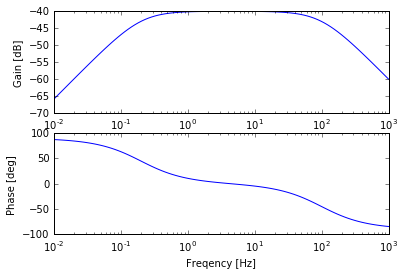

In [3]:
# SCC dynamics
T1 = 0.01
T2 = 5
num = [T1*T2, 0]
den = [T1*T2, T1+T2, 1]

scc = signal.lti(num,den)
w, mag, phase = signal.bode(scc)

fig, axs = plt.subplots(2,1)
axs[0].semilogx(w, mag)    # Bode magnitude plot
axs[0].set_ylabel('Gain [dB]')
axs[1].semilogx(w, phase)  # Bode phase plot
axs[1].set_ylabel('Phase [deg]')
axs[1].set_xlabel('Freqency [Hz]')

## Coding of Information in Neural Systems

1. Which neurons are active
2. Synchronicity between neurons
3. Frequency
4. Activity only with special stimulus characteristics
5. Time interval between action potentials

... but NOT by amplitude modulation!

ad 1) Stimulation of one semicircular canal elicits eye movement and movement perception in the plane of that canal.

ad 2) For example in the auditory system: * The Party Problem* - how do you seperate a voice from the background noise?

ad 3 and 4) *Tonic cells* and *phasic cells*: *tonic cells* are always active (e.g. indicating the tilt of the head), while *phasic cells* indicate a change, e.g. movement of the head.

ad 5) Important for the formation of new synapses: Hebbian rule - *"What fires together, wired together."*

## Secundary Information Processing

### Velocity Storage
Experiments have revealed that the decay of the slow-phase eye velocity (and the corresponding perception of rotation) is significantly slower than the return of the cupula to its resting state.

This extension of the time constant of the eye velocity can be simulated with a negative feedback loop:

<img src="data/images/Feedback_StateEstimation.png", width=500px>

\begin{gathered}
  \hat \omega  = ({S_{scc}} \cdot \omega ) \cdot k - {{\hat S}_{scc}} \cdot \hat \omega  \cdot k \hfill \\
  \hat \omega  = \frac{{({S_{scc}} \cdot \omega )}}{{{{\hat S}_{scc}} + \frac{1}{k}}}\,\,\xrightarrow{{k \to \infty }}\,\,\omega  \hfill \\ 
\end{gathered}

Such systems can be simulated very elegantely in *Matlab Simulink*

<img src="data/images/Feedback.png", width=500px>

or with the *Control System Toolbox*:

In [4]:
tout, outSignal, xout = signal.lsim(scc, x, t)

In [5]:
# The control package has to be installed manually.
# Unfortunately, it's syntax is slightly different from the one in scipy.signal
import control

scc = control.tf(num,den)
k = 100
feedback =control.series(scc, control.feedback(k, scc, sign=-1))
t_fb, x_fb = control.step_response(feedback)
plt.plot(tout, outSignal/np.max(outSignal), label='Cupula Displacement')
plt.plot(t_fb+1, x_fb/np.max(x_fb), label='Eye Velocity')
plt.xlim(0, 40)
plt.xlabel('Time [sec]')
plt.ylabel('Normalized Responses')
plt.legend()

ImportError: No module named 'control'

There exists physiological confirmation for the actual existance of such feedback loops: when the *corpus callosum* is severed, or in patients with *unilateral vestibular deafferentation*, the time constant of the eye velocity corresponds approximatley

### Neural Integrator

Healthy humans are also able to move the eye into an eccentric eye position - and keep them there:

<img src="data/images/Neural_Integrator.png", width=500px>

To generate the constant neural input required to *keep* the eye in an eccentric position, we need a *neural integrator* to obtain an *eye position* signal:

<img src="data/images/Neural-Integrator.gif", width=500px>

For horizontal eye movements, this integrator can be found in the *nucleus prepositus hypoglossi*; and for vertical/torsional eye movements, this integrator is located in the *nucleus of Cajal*.


### Push-Pull Principle

Without stimulation, haircells have a *resting firing rate* of approx 100 Hz.
To achieve good bidirectional response, otoliths and canals work in a *push-pull*
fashion. Activation of a canal on one side of the leg always inhibits the corresponding canal on the contralateral side. Comparison of the two canals determines the perception of rotation, with a linear response in both directions.
It is also explains the geometric arrangement of the six canals.

<img src="data/images/Semicircular_Canals.png", width=250px>

### Convergence

Some of the more complex properties of the vestibular system can be explained by the *spatio-temporal convergence* of vestibular signals in the vestibular nucleus (in the brainstem):

<img src="data/images/oto_canal_convergence.png", width=500px>

This feature can explain for example the generation of continuous compensatory eye movements during rotation about an earth-horizontal axis.


## Analysis

### Position from acceleration

* Select a *reference position*
* Define a coordinate system (typically a *right-handed* coordinate systems)
* Take the (discrete) velocity v(t)

\begin{equation}
    \vec{x}(t) = \vec{x}(0) + \sum_{i=1}^{n}{\vec{v}(t_i) dt}
\end{equation}

In [ ]:
# For example, calculate the position from a velocity step
from scipy.integrate import cumtrapz

# Set the experimenal parameters
rate = 50     # sample rate, in [Hz]
duration = 10  # [sec]
vel_max = 100
x0 = 0         # Initial potiion

# Simulate the velocity step
t = np.arange(duration*rate)/rate
vel = np.zeros(duration*rate)
vel[2*rate:]= vel_max  # deg/sec
vel[rate:2*rate] = np.linspace(0, vel_max, rate)

# Calculate the corresponding position in space
pos = cumtrapz(vel, dx=1/rate, initial=x0)

fig, axs = plt.subplots(2,1)
axs[0].plot(t, vel)
axs[0].set_ylabel('Velocity [m/s]')
axs[1].plot(t, pos)
axs[1].set_ylabel('Positoin [m]')
axs[1].set_xlabel('Time [sec]')

### Orientation from Angular Velocity

* Get to understand what *quaternions* are.
* Define a coordinate system (typically *right-handed* coordinate systems).
* Select a *reference orientation*, described by the quaternion $q_0$.
* Take the (discrete) velocity $\vec{\omega}(t)$.
* If the velocity describes the movement in a *body-centered coordinate system*, the orientation as a function of time $q(t)$ is given by

\begin{equation}
    q(t) = q(0) \circ \prod_{i=1}^{n}{q(t_i) dt}
\end{equation}

A *Python* implementation of this equation is implemented in the function $thLib.quat.vel2quat()$

<img src="data/images/Backward.png", align='left'> [Vestibular_1_MathDescription](Vestibular_1_MathDescription.ipynb)

    Author: Thomas Haslwanter
    Date: April 4, 2016
    Ver: 1.0

<img src="data/images/CCA_40.png">
*The Vestibular System*  is licensed under a Creative Commons Attribution 4.0 International License.